<a href="https://colab.research.google.com/github/HuangLorenzo/Esame_python/blob/main/Huang_lorenzo_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys,os,time
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

In [2]:
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.7 MB/s eta 0:00:00


In [3]:
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

CUDA Not Available


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
SFRH_simulazioni = np.load('/content/drive/MyDrive/Colab Notebooks/esamepython/SFRH_IllustrisTNG.npy')
param_simulazioni=np.loadtxt('/content/drive/MyDrive/Colab Notebooks/esamepython/params_IllustrisTNG.txt')

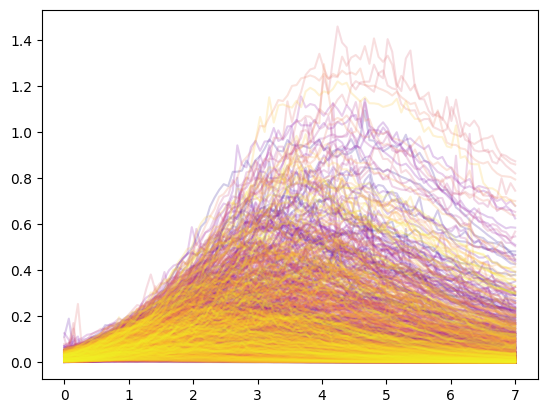

In [6]:
z=np.linspace(0.0, 7.0, 100)
cmap=plt.get_cmap('plasma')
colors=[cmap(i) for i in np.linspace(0,1,len(SFRH_simulazioni))]
for i in range(len(SFRH_simulazioni)):
  plt.plot(z,SFRH_simulazioni[i],c=colors[i], alpha=0.2)
plt.show()

In [32]:
seed           = 1                         #random seed to shuffle data before splitting into training, validation and testing
min_valid_loss_param = 1e10                       #set this to a large number. Used to later as threshold to save trained model
batch_size     = 12                        #number of elements each batch contains. Hyper-parameter
lr             = 1e-3                      #value of the learning rate. Hyper-parameter
wd             = 0.0                       #value of the weight decay. Hyper-parameter
dr             = 0.2                       #dropout rate. Hyper-parameter
epochs         = 500                       # max number of epochs to train the network. Hyper-parameter
patience       = 100                        # Number of epochs without improving the loss function to wait before updating the learning rate
stop_criterion = 200                        # Number of epochs without improving the loss function to wait before stopping the training
hidden_size    = 50                       #size of hidden layer (see nn.Linear)

f_model = 'best_model.pt'                  # Where to save the trained model

In [33]:
# This class creates the dataset
class make_dataset():

    def __init__(self, mode, x, y, seed):
        # # Normalize the value of the input
        min_x = np.min(x, axis=0)
        max_x = np.max(x, axis=0)
        x     = (x - min_x)/(max_x - min_x)

        # # Standardize the value of the ouput
        mean = np.mean(y, axis=0)
        std  = np.std(y,  axis=0)
        y = (y - mean)/std







        # get the number of training data
        n_training = x.shape[0]

        # get the size and offset depending on the type of dataset
        if   mode=='train':
            size, offset = int(n_training*0.70), int(n_training*0.00)
        elif mode=='valid':
            size, offset = int(n_training*0.15), int(n_training*0.70)
        elif mode=='test':
            size, offset = int(n_training*0.15), int(n_training*0.85)
        elif mode=='all':
            size, offset = int(n_training*1.00), int(n_training*0.00)
        else:    raise Exception('Wrong name!')

        # define size, input and output arrays containing the data
        self.size   = size
        self.input  = torch.zeros((size,100), dtype=torch.float) #array with x values
        self.output = torch.zeros((size,6),    dtype=torch.float) #array with y values

        # randomly shuffle the data. Instead of 0 1 2 3...999 have a
        # random permutation. E.g. 5 9 0 29...342
        np.random.seed(seed)
        indexes = np.arange(n_training)
        np.random.shuffle(indexes)
        indexes = indexes[offset:offset+size] #select indexes of the mode

        # get the corresponding x and y values
        self.input  = torch.tensor(x[indexes], dtype=torch.float32)
        self.output = torch.tensor(y[indexes], dtype=torch.float32)
        print(self.input.shape)
        print(self.output.shape)

        # self.output = self.output.view(self.output.shape[0],1) # same as unsqueeze

    # This protocol returns the size of the dataset
    def __len__(self):
        return self.size

    # This protocol returns
    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]

In [34]:
def create_dataset(mode, x, y, batch_size, seed):

    # create the class with the dataset
    data_set = make_dataset(mode, x, y, seed)

    # create the data loader
    return DataLoader(dataset=data_set, batch_size=batch_size, shuffle=True)

In [35]:
train_loader = create_dataset('train', SFRH_simulazioni, param_simulazioni, batch_size, seed)
valid_loader = create_dataset('valid', SFRH_simulazioni, param_simulazioni, batch_size, seed)
test_loader  = create_dataset('test', SFRH_simulazioni, param_simulazioni, batch_size, seed)

torch.Size([700, 100])
torch.Size([700, 6])
torch.Size([150, 100])
torch.Size([150, 6])
torch.Size([150, 100])
torch.Size([150, 6])


In [36]:
def model_builder(number_layers,hidden_size):
  layers=[]

  #creazione del modello
  layers.append(nn.Linear(100,hidden_size))
  for i in range(number_layers):
    layers.append(nn.LeakyReLU())
    layers.append(nn.Linear(hidden_size,hidden_size))
  layers[2*number_layers]=nn.Linear(hidden_size,6)

  return nn.Sequential(*layers)


In [37]:
#build a model
model=model_builder(3,hidden_size=hidden_size)
model=model.to(device)
print(model)

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

Sequential(
  (0): Linear(in_features=100, out_features=50, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=50, out_features=50, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=50, out_features=6, bias=True)
)


In [38]:
def nn_training(model,lr,epochs):

  min_valid_loss=min_valid_loss_param
  train_value=np.zeros(epochs)
  valid_value=np.zeros(epochs)
  global epoch_best_model

  # update the learning rate after patience-stesp if the loss function does not improve
  scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience, min_lr= 1.0e-6)



  #funzioneloss
  loss_func = nn.MSELoss()

  optimizer.zero_grad()

  for epoch in range(epochs):
    train_loss = 0.0
    points=0.0
    model.train()
    for i, (input, output) in enumerate(train_loader):
      # get the size of the batch
      bs = input.shape[0]

      #spostare i dati nel GPU se è disponibile
      input = input.to(device)
      output = output.to(device)

      #modello output
      output_pred = model(input)

      #calcolo scarto medio quadratico
      loss = loss_func(output_pred, output)

      #gradiente
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      #accumulo loss del ciclo sui batch
      train_loss += loss.item()*bs
      points+=bs

    # get the average training loss
    train_loss /= points
    train_value[epoch]=train_loss

    #validation
    valid_loss = 0.0
    points=0.0
    model.eval()


    #disattivo gradiente
    with torch.no_grad():

      #ciclo valid_batch
      for i, (input, output) in enumerate(valid_loader):
       # get the size of the batch
        bs = input.shape[0]

        #spostare i dati nel GPU se è disponibile
        input = input.to(device)
        output = output.to(device)

        #modello output
        output_pred = model(input)

        #calcolo scarto medio quadratico
        loss = loss_func(output_pred, output)

        #accumula loss
        valid_loss += (loss.item())*bs
        points     += bs

      valid_loss/=points
      valid_value[epoch]=valid_loss

    #attivo scheduler
    scheduler.step(valid_loss)

    # save model if it has a lower validation loss
    print(f'epoch:{epoch}, valid loss: {valid_loss:.4f}', end='')
    if valid_loss<min_valid_loss:
        torch.save(model.state_dict(), f_model)
        min_valid_loss = valid_loss
        epoch_best_model=epoch
        print(' (best-model)')
    else:
        print('')

    if epoch - epoch_best_model > stop_criterion:
        print ('Training stop at epoch:',epoch,' because the best model does not imporved after ',stop_criterion,' epochs')
        break
  return train_value,valid_value,min_valid_loss

In [39]:
train_value,valid_value,_=nn_training(model=model,lr=lr,epochs=epochs)

epoch:0, valid loss: 0.7826 (best-model)
epoch:1, valid loss: 0.7183 (best-model)
epoch:2, valid loss: 0.6847 (best-model)
epoch:3, valid loss: 0.6702 (best-model)
epoch:4, valid loss: 0.6653 (best-model)
epoch:5, valid loss: 0.6593 (best-model)
epoch:6, valid loss: 0.6519 (best-model)
epoch:7, valid loss: 0.6454 (best-model)
epoch:8, valid loss: 0.6384 (best-model)
epoch:9, valid loss: 0.6264 (best-model)
epoch:10, valid loss: 0.6243 (best-model)
epoch:11, valid loss: 0.6107 (best-model)
epoch:12, valid loss: 0.6345
epoch:13, valid loss: 0.6087 (best-model)
epoch:14, valid loss: 0.6075 (best-model)
epoch:15, valid loss: 0.6091
epoch:16, valid loss: 0.6045 (best-model)
epoch:17, valid loss: 0.6001 (best-model)
epoch:18, valid loss: 0.5965 (best-model)
epoch:19, valid loss: 0.5966
epoch:20, valid loss: 0.5891 (best-model)
epoch:21, valid loss: 0.6196
epoch:22, valid loss: 0.5779 (best-model)
epoch:23, valid loss: 0.5891
epoch:24, valid loss: 0.5769 (best-model)
epoch:25, valid loss: 0.5

[]

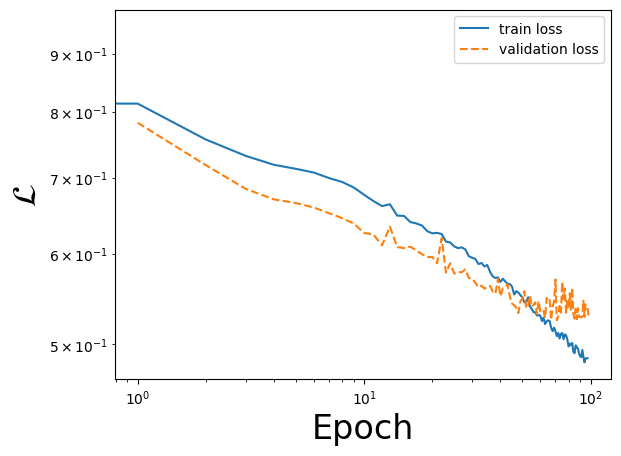

In [40]:
epoche=np.arange(epoch_best_model)

plt.plot(epoche,train_value[:epoch_best_model],label='train loss')
plt.plot(epoche+1,valid_value[:epoch_best_model],ls='--',label='validation loss')

plt.xlabel("Epoch", fontsize=24)
plt.ylabel("$\mathcal{L}$", fontsize=24)
plt.legend()
plt.loglog()

In [20]:
def objective(trial):
  params = {
      'number_layers': trial.suggest_int('number_layers', 1, 4,),
      'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
      'epochs': trial.suggest_int("epochs", 100, 500),
      'hidden_size': trial.suggest_int("hidden_size", 50, 100) # number of hidden parameters
       }
  #salvo i nuovi parametri
  number_layers=params['number_layers']
  hidden_size=params['hidden_size']
  lr=params['learning_rate']
  epochs=params['epochs']

  #costruisco modello
  model=model_builder(number_layers=number_layers,hidden_size=hidden_size)
  model=model.to(device)

  #accuracy
  _,_,accuracy=nn_training(model=model,lr=lr,epochs=epochs)

  trial.report(accuracy, epochs)
  return accuracy




In [21]:
# Let's also add a method (prune) to terminate unpromising trials in the early stages of the training process
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.PercentilePruner(80.))
study.optimize(objective, n_trials=30)

[I 2025-02-16 16:55:45,952] A new study created in memory with name: no-name-5b18a75a-e019-4d3e-810e-823ebca9d43e
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([12, 1, 6])) that is different to the input size (torch.Size([12, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([4, 1, 6])) that is different to the input size (torch.Size([4, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([6, 1, 6])) that is different to the input size (torch.Size([6, 6])). T

epoch:0, valid loss: 0.9974 (best-model)
epoch:1, valid loss: 0.9973 (best-model)
epoch:2, valid loss: 0.9969 (best-model)
epoch:3, valid loss: 0.9970
epoch:4, valid loss: 0.9971
epoch:5, valid loss: 0.9967 (best-model)
epoch:6, valid loss: 0.9966 (best-model)
epoch:7, valid loss: 0.9973
epoch:8, valid loss: 0.9972
epoch:9, valid loss: 0.9971
epoch:10, valid loss: 0.9968
epoch:11, valid loss: 0.9973
epoch:12, valid loss: 0.9975
epoch:13, valid loss: 0.9973
epoch:14, valid loss: 0.9971
epoch:15, valid loss: 0.9968
epoch:16, valid loss: 0.9970
epoch:17, valid loss: 0.9972
epoch:18, valid loss: 0.9972
epoch:19, valid loss: 0.9969
epoch:20, valid loss: 0.9965 (best-model)
epoch:21, valid loss: 0.9967
epoch:22, valid loss: 0.9969
epoch:23, valid loss: 0.9966
epoch:24, valid loss: 0.9973
epoch:25, valid loss: 0.9966
epoch:26, valid loss: 0.9974
epoch:27, valid loss: 0.9968
epoch:28, valid loss: 0.9967
epoch:29, valid loss: 0.9971
epoch:30, valid loss: 0.9972
epoch:31, valid loss: 0.9973
epoc

[I 2025-02-16 16:56:30,986] Trial 0 finished with value: 0.9962714290618897 and parameters: {'number_layers': 2, 'learning_rate': 0.002983872826404053, 'epochs': 434, 'hidden_size': 68}. Best is trial 0 with value: 0.9962714290618897.


epoch:432, valid loss: 0.9970
epoch:433, valid loss: 0.9973
epoch:0, valid loss: 1.0016 (best-model)
epoch:1, valid loss: 1.0016 (best-model)
epoch:2, valid loss: 1.0017
epoch:3, valid loss: 1.0016 (best-model)
epoch:4, valid loss: 1.0017
epoch:5, valid loss: 1.0016
epoch:6, valid loss: 1.0017
epoch:7, valid loss: 1.0016
epoch:8, valid loss: 1.0017
epoch:9, valid loss: 1.0016
epoch:10, valid loss: 1.0016
epoch:11, valid loss: 1.0016
epoch:12, valid loss: 1.0016
epoch:13, valid loss: 1.0016
epoch:14, valid loss: 1.0017
epoch:15, valid loss: 1.0016
epoch:16, valid loss: 1.0016
epoch:17, valid loss: 1.0016
epoch:18, valid loss: 1.0016
epoch:19, valid loss: 1.0016
epoch:20, valid loss: 1.0017
epoch:21, valid loss: 1.0017
epoch:22, valid loss: 1.0016
epoch:23, valid loss: 1.0016
epoch:24, valid loss: 1.0017
epoch:25, valid loss: 1.0016
epoch:26, valid loss: 1.0015 (best-model)
epoch:27, valid loss: 1.0016
epoch:28, valid loss: 1.0016
epoch:29, valid loss: 1.0017
epoch:30, valid loss: 1.0016

[I 2025-02-16 16:56:50,707] Trial 1 finished with value: 1.0015256643295287 and parameters: {'number_layers': 4, 'learning_rate': 0.04155305963023206, 'epochs': 157, 'hidden_size': 81}. Best is trial 0 with value: 0.9962714290618897.


epoch:156, valid loss: 1.0017
epoch:0, valid loss: 0.9871 (best-model)
epoch:1, valid loss: 0.9874
epoch:2, valid loss: 0.9868 (best-model)
epoch:3, valid loss: 0.9871
epoch:4, valid loss: 0.9873
epoch:5, valid loss: 0.9870
epoch:6, valid loss: 0.9863 (best-model)
epoch:7, valid loss: 0.9863
epoch:8, valid loss: 0.9872
epoch:9, valid loss: 0.9865
epoch:10, valid loss: 0.9861 (best-model)
epoch:11, valid loss: 0.9874
epoch:12, valid loss: 0.9870
epoch:13, valid loss: 0.9880
epoch:14, valid loss: 0.9871
epoch:15, valid loss: 0.9877
epoch:16, valid loss: 0.9867
epoch:17, valid loss: 0.9868
epoch:18, valid loss: 0.9858 (best-model)
epoch:19, valid loss: 0.9862
epoch:20, valid loss: 0.9888
epoch:21, valid loss: 0.9864
epoch:22, valid loss: 0.9869
epoch:23, valid loss: 0.9871
epoch:24, valid loss: 0.9850 (best-model)
epoch:25, valid loss: 0.9863
epoch:26, valid loss: 0.9870
epoch:27, valid loss: 0.9867
epoch:28, valid loss: 0.9875
epoch:29, valid loss: 0.9866
epoch:30, valid loss: 0.9862
epo

[I 2025-02-16 16:57:10,680] Trial 2 finished with value: 0.9843473148345947 and parameters: {'number_layers': 1, 'learning_rate': 0.009991804648262027, 'epochs': 228, 'hidden_size': 94}. Best is trial 2 with value: 0.9843473148345947.


epoch:225, valid loss: 0.9867
epoch:226, valid loss: 0.9863
epoch:227, valid loss: 0.9862
epoch:0, valid loss: 0.9835 (best-model)
epoch:1, valid loss: 0.9833 (best-model)
epoch:2, valid loss: 0.9836
epoch:3, valid loss: 0.9835
epoch:4, valid loss: 0.9836
epoch:5, valid loss: 0.9837
epoch:6, valid loss: 0.9833
epoch:7, valid loss: 0.9833 (best-model)
epoch:8, valid loss: 0.9835
epoch:9, valid loss: 0.9834
epoch:10, valid loss: 0.9835
epoch:11, valid loss: 0.9837
epoch:12, valid loss: 0.9837
epoch:13, valid loss: 0.9836
epoch:14, valid loss: 0.9833
epoch:15, valid loss: 0.9836
epoch:16, valid loss: 0.9837
epoch:17, valid loss: 0.9833
epoch:18, valid loss: 0.9836
epoch:19, valid loss: 0.9836
epoch:20, valid loss: 0.9831 (best-model)
epoch:21, valid loss: 0.9835
epoch:22, valid loss: 0.9831
epoch:23, valid loss: 0.9835
epoch:24, valid loss: 0.9833
epoch:25, valid loss: 0.9830 (best-model)
epoch:26, valid loss: 0.9835
epoch:27, valid loss: 0.9836
epoch:28, valid loss: 0.9836
epoch:29, vali

[I 2025-02-16 16:57:36,064] Trial 3 finished with value: 0.9828440713882446 and parameters: {'number_layers': 2, 'learning_rate': 0.00017451241785829008, 'epochs': 257, 'hidden_size': 79}. Best is trial 3 with value: 0.9828440713882446.


epoch:255, valid loss: 0.9832
epoch:256, valid loss: 0.9837
epoch:0, valid loss: 0.9965 (best-model)
epoch:1, valid loss: 0.9962 (best-model)
epoch:2, valid loss: 0.9974
epoch:3, valid loss: 0.9963
epoch:4, valid loss: 0.9970
epoch:5, valid loss: 0.9958 (best-model)
epoch:6, valid loss: 0.9972
epoch:7, valid loss: 0.9965
epoch:8, valid loss: 0.9967
epoch:9, valid loss: 0.9969
epoch:10, valid loss: 0.9954 (best-model)
epoch:11, valid loss: 0.9967
epoch:12, valid loss: 0.9964
epoch:13, valid loss: 0.9969
epoch:14, valid loss: 0.9971
epoch:15, valid loss: 0.9978
epoch:16, valid loss: 0.9962
epoch:17, valid loss: 0.9958
epoch:18, valid loss: 0.9967
epoch:19, valid loss: 0.9955
epoch:20, valid loss: 0.9973
epoch:21, valid loss: 0.9957
epoch:22, valid loss: 0.9978
epoch:23, valid loss: 0.9969
epoch:24, valid loss: 0.9966
epoch:25, valid loss: 0.9966
epoch:26, valid loss: 0.9958
epoch:27, valid loss: 0.9968
epoch:28, valid loss: 0.9967
epoch:29, valid loss: 0.9957
epoch:30, valid loss: 0.9956

[I 2025-02-16 16:57:50,811] Trial 4 finished with value: 0.9948218488693237 and parameters: {'number_layers': 1, 'learning_rate': 0.002802999770325438, 'epochs': 171, 'hidden_size': 85}. Best is trial 3 with value: 0.9828440713882446.


epoch:168, valid loss: 0.9966
epoch:169, valid loss: 0.9962
epoch:170, valid loss: 0.9962
epoch:0, valid loss: 0.9858 (best-model)
epoch:1, valid loss: 0.9860
epoch:2, valid loss: 0.9858 (best-model)
epoch:3, valid loss: 0.9861
epoch:4, valid loss: 0.9860
epoch:5, valid loss: 0.9863
epoch:6, valid loss: 0.9853 (best-model)
epoch:7, valid loss: 0.9860
epoch:8, valid loss: 0.9853
epoch:9, valid loss: 0.9848 (best-model)
epoch:10, valid loss: 0.9857
epoch:11, valid loss: 0.9856
epoch:12, valid loss: 0.9856
epoch:13, valid loss: 0.9848
epoch:14, valid loss: 0.9860
epoch:15, valid loss: 0.9860
epoch:16, valid loss: 0.9859
epoch:17, valid loss: 0.9859
epoch:18, valid loss: 0.9860
epoch:19, valid loss: 0.9849
epoch:20, valid loss: 0.9858
epoch:21, valid loss: 0.9856
epoch:22, valid loss: 0.9862
epoch:23, valid loss: 0.9852
epoch:24, valid loss: 0.9853
epoch:25, valid loss: 0.9860
epoch:26, valid loss: 0.9843 (best-model)
epoch:27, valid loss: 0.9857
epoch:28, valid loss: 0.9849
epoch:29, vali

[I 2025-02-16 16:58:26,479] Trial 5 finished with value: 0.9836190938949585 and parameters: {'number_layers': 1, 'learning_rate': 0.04086352450113667, 'epochs': 408, 'hidden_size': 88}. Best is trial 3 with value: 0.9828440713882446.


epoch:407, valid loss: 0.9858
epoch:0, valid loss: 0.9928 (best-model)
epoch:1, valid loss: 0.9922 (best-model)
epoch:2, valid loss: 0.9924
epoch:3, valid loss: 0.9919 (best-model)
epoch:4, valid loss: 0.9928
epoch:5, valid loss: 0.9926
epoch:6, valid loss: 0.9917 (best-model)
epoch:7, valid loss: 0.9927
epoch:8, valid loss: 0.9921
epoch:9, valid loss: 0.9922
epoch:10, valid loss: 0.9929
epoch:11, valid loss: 0.9927
epoch:12, valid loss: 0.9922
epoch:13, valid loss: 0.9924
epoch:14, valid loss: 0.9924
epoch:15, valid loss: 0.9912 (best-model)
epoch:16, valid loss: 0.9925
epoch:17, valid loss: 0.9922
epoch:18, valid loss: 0.9915
epoch:19, valid loss: 0.9920
epoch:20, valid loss: 0.9918
epoch:21, valid loss: 0.9921
epoch:22, valid loss: 0.9923
epoch:23, valid loss: 0.9922
epoch:24, valid loss: 0.9919
epoch:25, valid loss: 0.9930
epoch:26, valid loss: 0.9915
epoch:27, valid loss: 0.9925
epoch:28, valid loss: 0.9919
epoch:29, valid loss: 0.9923
epoch:30, valid loss: 0.9923
epoch:31, valid 

[I 2025-02-16 16:59:00,121] Trial 6 finished with value: 0.9903138160705567 and parameters: {'number_layers': 2, 'learning_rate': 0.0016493904704981534, 'epochs': 338, 'hidden_size': 52}. Best is trial 3 with value: 0.9828440713882446.


epoch:337, valid loss: 0.9905
epoch:0, valid loss: 1.0049 (best-model)
epoch:1, valid loss: 1.0049
epoch:2, valid loss: 1.0049
epoch:3, valid loss: 1.0049
epoch:4, valid loss: 1.0049
epoch:5, valid loss: 1.0049
epoch:6, valid loss: 1.0048 (best-model)
epoch:7, valid loss: 1.0048 (best-model)
epoch:8, valid loss: 1.0049
epoch:9, valid loss: 1.0049
epoch:10, valid loss: 1.0049
epoch:11, valid loss: 1.0049
epoch:12, valid loss: 1.0049
epoch:13, valid loss: 1.0048
epoch:14, valid loss: 1.0049
epoch:15, valid loss: 1.0049
epoch:16, valid loss: 1.0049
epoch:17, valid loss: 1.0049
epoch:18, valid loss: 1.0049
epoch:19, valid loss: 1.0049
epoch:20, valid loss: 1.0049
epoch:21, valid loss: 1.0048
epoch:22, valid loss: 1.0049
epoch:23, valid loss: 1.0050
epoch:24, valid loss: 1.0049
epoch:25, valid loss: 1.0048
epoch:26, valid loss: 1.0050
epoch:27, valid loss: 1.0048
epoch:28, valid loss: 1.0049
epoch:29, valid loss: 1.0049
epoch:30, valid loss: 1.0049
epoch:31, valid loss: 1.0049
epoch:32, val

[I 2025-02-16 16:59:29,767] Trial 7 finished with value: 1.0047862863540649 and parameters: {'number_layers': 4, 'learning_rate': 0.002118389336683677, 'epochs': 313, 'hidden_size': 100}. Best is trial 3 with value: 0.9828440713882446.


epoch:237, valid loss: 1.0049
epoch:238, valid loss: 1.0049
Training stop at epoch: 238  because the best model does not imporved after  200  epochs
epoch:0, valid loss: 0.9898 (best-model)
epoch:1, valid loss: 0.9899
epoch:2, valid loss: 0.9899
epoch:3, valid loss: 0.9897 (best-model)
epoch:4, valid loss: 0.9899
epoch:5, valid loss: 0.9897
epoch:6, valid loss: 0.9899
epoch:7, valid loss: 0.9898
epoch:8, valid loss: 0.9897 (best-model)
epoch:9, valid loss: 0.9899
epoch:10, valid loss: 0.9899
epoch:11, valid loss: 0.9899
epoch:12, valid loss: 0.9899
epoch:13, valid loss: 0.9898
epoch:14, valid loss: 0.9898
epoch:15, valid loss: 0.9899
epoch:16, valid loss: 0.9899
epoch:17, valid loss: 0.9898
epoch:18, valid loss: 0.9898
epoch:19, valid loss: 0.9898
epoch:20, valid loss: 0.9898
epoch:21, valid loss: 0.9899
epoch:22, valid loss: 0.9898
epoch:23, valid loss: 0.9898
epoch:24, valid loss: 0.9897
epoch:25, valid loss: 0.9900
epoch:26, valid loss: 0.9898
epoch:27, valid loss: 0.9898
epoch:28, 

[I 2025-02-16 17:00:22,902] Trial 8 finished with value: 0.9895816373825074 and parameters: {'number_layers': 4, 'learning_rate': 0.09161065531528445, 'epochs': 470, 'hidden_size': 88}. Best is trial 3 with value: 0.9828440713882446.


epoch:428, valid loss: 0.9899
epoch:429, valid loss: 0.9899
Training stop at epoch: 429  because the best model does not imporved after  200  epochs
epoch:0, valid loss: 0.9895 (best-model)
epoch:1, valid loss: 0.9895
epoch:2, valid loss: 0.9897
epoch:3, valid loss: 0.9895 (best-model)
epoch:4, valid loss: 0.9895
epoch:5, valid loss: 0.9897
epoch:6, valid loss: 0.9895
epoch:7, valid loss: 0.9896
epoch:8, valid loss: 0.9895
epoch:9, valid loss: 0.9895
epoch:10, valid loss: 0.9896
epoch:11, valid loss: 0.9895
epoch:12, valid loss: 0.9895
epoch:13, valid loss: 0.9895 (best-model)
epoch:14, valid loss: 0.9894 (best-model)
epoch:15, valid loss: 0.9894
epoch:16, valid loss: 0.9896
epoch:17, valid loss: 0.9897
epoch:18, valid loss: 0.9896
epoch:19, valid loss: 0.9895
epoch:20, valid loss: 0.9896
epoch:21, valid loss: 0.9895
epoch:22, valid loss: 0.9896
epoch:23, valid loss: 0.9896
epoch:24, valid loss: 0.9895
epoch:25, valid loss: 0.9894 (best-model)
epoch:26, valid loss: 0.9896
epoch:27, val

[I 2025-02-16 17:00:48,521] Trial 9 finished with value: 0.9892240858078003 and parameters: {'number_layers': 3, 'learning_rate': 0.0586393356814929, 'epochs': 229, 'hidden_size': 76}. Best is trial 3 with value: 0.9828440713882446.


epoch:227, valid loss: 0.9896
epoch:228, valid loss: 0.9895
epoch:0, valid loss: 0.9902 (best-model)
epoch:1, valid loss: 0.9901 (best-model)
epoch:2, valid loss: 0.9900 (best-model)
epoch:3, valid loss: 0.9902
epoch:4, valid loss: 0.9899 (best-model)
epoch:5, valid loss: 0.9903
epoch:6, valid loss: 0.9901
epoch:7, valid loss: 0.9902
epoch:8, valid loss: 0.9903
epoch:9, valid loss: 0.9903
epoch:10, valid loss: 0.9901
epoch:11, valid loss: 0.9904
epoch:12, valid loss: 0.9901
epoch:13, valid loss: 0.9903
epoch:14, valid loss: 0.9901
epoch:15, valid loss: 0.9900
epoch:16, valid loss: 0.9902
epoch:17, valid loss: 0.9902
epoch:18, valid loss: 0.9903
epoch:19, valid loss: 0.9902
epoch:20, valid loss: 0.9898 (best-model)
epoch:21, valid loss: 0.9900
epoch:22, valid loss: 0.9902
epoch:23, valid loss: 0.9901
epoch:24, valid loss: 0.9899
epoch:25, valid loss: 0.9899
epoch:26, valid loss: 0.9902
epoch:27, valid loss: 0.9901
epoch:28, valid loss: 0.9902
epoch:29, valid loss: 0.9898 (best-model)
ep

[I 2025-02-16 17:01:16,762] Trial 10 finished with value: 0.9896275305747986 and parameters: {'number_layers': 3, 'learning_rate': 0.00010451952019982128, 'epochs': 252, 'hidden_size': 65}. Best is trial 3 with value: 0.9828440713882446.


epoch:251, valid loss: 0.9900
epoch:0, valid loss: 0.9874 (best-model)
epoch:1, valid loss: 0.9879
epoch:2, valid loss: 0.9873 (best-model)
epoch:3, valid loss: 0.9871 (best-model)
epoch:4, valid loss: 0.9864 (best-model)
epoch:5, valid loss: 0.9876
epoch:6, valid loss: 0.9880
epoch:7, valid loss: 0.9881
epoch:8, valid loss: 0.9853 (best-model)
epoch:9, valid loss: 0.9855
epoch:10, valid loss: 0.9877
epoch:11, valid loss: 0.9876
epoch:12, valid loss: 0.9870
epoch:13, valid loss: 0.9856
epoch:14, valid loss: 0.9868
epoch:15, valid loss: 0.9864
epoch:16, valid loss: 0.9878
epoch:17, valid loss: 0.9879
epoch:18, valid loss: 0.9874
epoch:19, valid loss: 0.9864
epoch:20, valid loss: 0.9881
epoch:21, valid loss: 0.9869
epoch:22, valid loss: 0.9875
epoch:23, valid loss: 0.9882
epoch:24, valid loss: 0.9880
epoch:25, valid loss: 0.9876
epoch:26, valid loss: 0.9877
epoch:27, valid loss: 0.9850 (best-model)
epoch:28, valid loss: 0.9861
epoch:29, valid loss: 0.9854
epoch:30, valid loss: 0.9879
epo

[I 2025-02-16 17:01:36,393] Trial 11 finished with value: 0.9850299620628357 and parameters: {'number_layers': 1, 'learning_rate': 0.00021235420603192017, 'epochs': 390, 'hidden_size': 71}. Best is trial 3 with value: 0.9828440713882446.


epoch:228, valid loss: 0.9871
Training stop at epoch: 228  because the best model does not imporved after  200  epochs
epoch:0, valid loss: 1.0087 (best-model)
epoch:1, valid loss: 1.0096
epoch:2, valid loss: 1.0097
epoch:3, valid loss: 1.0093
epoch:4, valid loss: 1.0093
epoch:5, valid loss: 1.0093
epoch:6, valid loss: 1.0095
epoch:7, valid loss: 1.0100
epoch:8, valid loss: 1.0095
epoch:9, valid loss: 1.0096
epoch:10, valid loss: 1.0093
epoch:11, valid loss: 1.0098
epoch:12, valid loss: 1.0095
epoch:13, valid loss: 1.0095
epoch:14, valid loss: 1.0095
epoch:15, valid loss: 1.0091
epoch:16, valid loss: 1.0093
epoch:17, valid loss: 1.0094
epoch:18, valid loss: 1.0098
epoch:19, valid loss: 1.0094
epoch:20, valid loss: 1.0093
epoch:21, valid loss: 1.0096
epoch:22, valid loss: 1.0094
epoch:23, valid loss: 1.0095
epoch:24, valid loss: 1.0099
epoch:25, valid loss: 1.0095
epoch:26, valid loss: 1.0093
epoch:27, valid loss: 1.0094
epoch:28, valid loss: 1.0104
epoch:29, valid loss: 1.0096
epoch:30

[I 2025-02-16 17:01:56,631] Trial 12 finished with value: 1.0087465596199037 and parameters: {'number_layers': 2, 'learning_rate': 0.0004857434719339943, 'epochs': 373, 'hidden_size': 90}. Best is trial 3 with value: 0.9828440713882446.


epoch:199, valid loss: 1.0096
epoch:200, valid loss: 1.0096
epoch:201, valid loss: 1.0099
Training stop at epoch: 201  because the best model does not imporved after  200  epochs
epoch:0, valid loss: 0.9930 (best-model)
epoch:1, valid loss: 0.9907 (best-model)
epoch:2, valid loss: 0.9927
epoch:3, valid loss: 0.9915
epoch:4, valid loss: 0.9919
epoch:5, valid loss: 0.9916
epoch:6, valid loss: 0.9915
epoch:7, valid loss: 0.9925
epoch:8, valid loss: 0.9927
epoch:9, valid loss: 0.9916
epoch:10, valid loss: 0.9913
epoch:11, valid loss: 0.9918
epoch:12, valid loss: 0.9914
epoch:13, valid loss: 0.9910
epoch:14, valid loss: 0.9913
epoch:15, valid loss: 0.9912
epoch:16, valid loss: 0.9925
epoch:17, valid loss: 0.9924
epoch:18, valid loss: 0.9916
epoch:19, valid loss: 0.9924
epoch:20, valid loss: 0.9921
epoch:21, valid loss: 0.9917
epoch:22, valid loss: 0.9925
epoch:23, valid loss: 0.9924
epoch:24, valid loss: 0.9919
epoch:25, valid loss: 0.9917
epoch:26, valid loss: 0.9926
epoch:27, valid loss: 

[I 2025-02-16 17:02:20,882] Trial 13 finished with value: 0.9898857975006103 and parameters: {'number_layers': 1, 'learning_rate': 0.012786726768355714, 'epochs': 280, 'hidden_size': 78}. Best is trial 3 with value: 0.9828440713882446.


epoch:279, valid loss: 0.9911
epoch:0, valid loss: 1.0002 (best-model)
epoch:1, valid loss: 1.0002
epoch:2, valid loss: 1.0003
epoch:3, valid loss: 1.0000 (best-model)
epoch:4, valid loss: 1.0001
epoch:5, valid loss: 1.0002
epoch:6, valid loss: 0.9999 (best-model)
epoch:7, valid loss: 1.0001
epoch:8, valid loss: 1.0003
epoch:9, valid loss: 1.0001
epoch:10, valid loss: 1.0002
epoch:11, valid loss: 1.0001
epoch:12, valid loss: 0.9996 (best-model)
epoch:13, valid loss: 1.0001
epoch:14, valid loss: 1.0001
epoch:15, valid loss: 1.0003
epoch:16, valid loss: 1.0003
epoch:17, valid loss: 0.9997
epoch:18, valid loss: 1.0004
epoch:19, valid loss: 1.0003
epoch:20, valid loss: 1.0001
epoch:21, valid loss: 1.0004
epoch:22, valid loss: 1.0003
epoch:23, valid loss: 0.9998
epoch:24, valid loss: 0.9999
epoch:25, valid loss: 0.9997
epoch:26, valid loss: 1.0000
epoch:27, valid loss: 0.9999
epoch:28, valid loss: 0.9999
epoch:29, valid loss: 0.9997
epoch:30, valid loss: 1.0007
epoch:31, valid loss: 1.0006


[I 2025-02-16 17:02:31,735] Trial 14 finished with value: 0.9995384597778321 and parameters: {'number_layers': 2, 'learning_rate': 0.0006371196822234972, 'epochs': 112, 'hidden_size': 61}. Best is trial 3 with value: 0.9828440713882446.


epoch:109, valid loss: 1.0003
epoch:110, valid loss: 1.0001
epoch:111, valid loss: 1.0005
epoch:0, valid loss: 0.9921 (best-model)
epoch:1, valid loss: 0.9922
epoch:2, valid loss: 0.9922
epoch:3, valid loss: 0.9921 (best-model)
epoch:4, valid loss: 0.9920 (best-model)
epoch:5, valid loss: 0.9921
epoch:6, valid loss: 0.9924
epoch:7, valid loss: 0.9921
epoch:8, valid loss: 0.9921
epoch:9, valid loss: 0.9922
epoch:10, valid loss: 0.9922
epoch:11, valid loss: 0.9923
epoch:12, valid loss: 0.9923
epoch:13, valid loss: 0.9922
epoch:14, valid loss: 0.9923
epoch:15, valid loss: 0.9923
epoch:16, valid loss: 0.9922
epoch:17, valid loss: 0.9920 (best-model)
epoch:18, valid loss: 0.9922
epoch:19, valid loss: 0.9920
epoch:20, valid loss: 0.9921
epoch:21, valid loss: 0.9921
epoch:22, valid loss: 0.9922
epoch:23, valid loss: 0.9921
epoch:24, valid loss: 0.9922
epoch:25, valid loss: 0.9920 (best-model)
epoch:26, valid loss: 0.9923
epoch:27, valid loss: 0.9922
epoch:28, valid loss: 0.9921
epoch:29, vali

[I 2025-02-16 17:03:23,887] Trial 15 finished with value: 0.9919251203536987 and parameters: {'number_layers': 3, 'learning_rate': 0.012874400415497853, 'epochs': 481, 'hidden_size': 98}. Best is trial 3 with value: 0.9828440713882446.


epoch:468, valid loss: 0.9922
epoch:469, valid loss: 0.9921
Training stop at epoch: 469  because the best model does not imporved after  200  epochs
epoch:0, valid loss: 1.0002 (best-model)
epoch:1, valid loss: 0.9997 (best-model)
epoch:2, valid loss: 1.0010
epoch:3, valid loss: 1.0007
epoch:4, valid loss: 0.9999
epoch:5, valid loss: 1.0006
epoch:6, valid loss: 1.0017
epoch:7, valid loss: 1.0016
epoch:8, valid loss: 0.9995 (best-model)
epoch:9, valid loss: 1.0018
epoch:10, valid loss: 1.0008
epoch:11, valid loss: 0.9997
epoch:12, valid loss: 1.0000
epoch:13, valid loss: 1.0009
epoch:14, valid loss: 1.0006
epoch:15, valid loss: 1.0015
epoch:16, valid loss: 1.0016
epoch:17, valid loss: 0.9996
epoch:18, valid loss: 0.9996
epoch:19, valid loss: 0.9999
epoch:20, valid loss: 1.0005
epoch:21, valid loss: 0.9996
epoch:22, valid loss: 1.0007
epoch:23, valid loss: 1.0004
epoch:24, valid loss: 1.0012
epoch:25, valid loss: 1.0011
epoch:26, valid loss: 0.9999
epoch:27, valid loss: 1.0024
epoch:28, 

[I 2025-02-16 17:03:45,372] Trial 16 finished with value: 0.9986680841445923 and parameters: {'number_layers': 1, 'learning_rate': 0.025748629614576485, 'epochs': 401, 'hidden_size': 83}. Best is trial 3 with value: 0.9828440713882446.


epoch:250, valid loss: 1.0003
epoch:251, valid loss: 1.0009
Training stop at epoch: 251  because the best model does not imporved after  200  epochs
epoch:0, valid loss: 0.9906 (best-model)
epoch:1, valid loss: 0.9906
epoch:2, valid loss: 0.9902 (best-model)
epoch:3, valid loss: 0.9908
epoch:4, valid loss: 0.9905
epoch:5, valid loss: 0.9904
epoch:6, valid loss: 0.9902
epoch:7, valid loss: 0.9905
epoch:8, valid loss: 0.9899 (best-model)
epoch:9, valid loss: 0.9906
epoch:10, valid loss: 0.9905
epoch:11, valid loss: 0.9902
epoch:12, valid loss: 0.9907
epoch:13, valid loss: 0.9900
epoch:14, valid loss: 0.9902
epoch:15, valid loss: 0.9903
epoch:16, valid loss: 0.9905
epoch:17, valid loss: 0.9905
epoch:18, valid loss: 0.9905
epoch:19, valid loss: 0.9904
epoch:20, valid loss: 0.9902
epoch:21, valid loss: 0.9908
epoch:22, valid loss: 0.9904
epoch:23, valid loss: 0.9900
epoch:24, valid loss: 0.9904
epoch:25, valid loss: 0.9902
epoch:26, valid loss: 0.9903
epoch:27, valid loss: 0.9896 (best-mode

[I 2025-02-16 17:04:11,080] Trial 17 finished with value: 0.9894792795181274 and parameters: {'number_layers': 2, 'learning_rate': 0.00038723365834211396, 'epochs': 338, 'hidden_size': 92}. Best is trial 3 with value: 0.9828440713882446.


epoch:259, valid loss: 0.9899
epoch:260, valid loss: 0.9903
Training stop at epoch: 260  because the best model does not imporved after  200  epochs
epoch:0, valid loss: 1.0058 (best-model)
epoch:1, valid loss: 1.0058 (best-model)
epoch:2, valid loss: 1.0055 (best-model)
epoch:3, valid loss: 1.0059
epoch:4, valid loss: 1.0036 (best-model)
epoch:5, valid loss: 1.0062
epoch:6, valid loss: 1.0051
epoch:7, valid loss: 1.0062
epoch:8, valid loss: 1.0045
epoch:9, valid loss: 1.0044
epoch:10, valid loss: 1.0058
epoch:11, valid loss: 1.0075
epoch:12, valid loss: 1.0056
epoch:13, valid loss: 1.0025 (best-model)
epoch:14, valid loss: 1.0050
epoch:15, valid loss: 1.0048
epoch:16, valid loss: 1.0061
epoch:17, valid loss: 1.0058
epoch:18, valid loss: 1.0042
epoch:19, valid loss: 1.0048
epoch:20, valid loss: 1.0057
epoch:21, valid loss: 1.0059
epoch:22, valid loss: 1.0061
epoch:23, valid loss: 1.0058
epoch:24, valid loss: 1.0049
epoch:25, valid loss: 1.0048
epoch:26, valid loss: 1.0060
epoch:27, val

[I 2025-02-16 17:04:29,360] Trial 18 finished with value: 1.0025344944000245 and parameters: {'number_layers': 1, 'learning_rate': 0.0010221993978775238, 'epochs': 430, 'hidden_size': 74}. Best is trial 3 with value: 0.9828440713882446.


epoch:213, valid loss: 1.0056
epoch:214, valid loss: 1.0057
Training stop at epoch: 214  because the best model does not imporved after  200  epochs
epoch:0, valid loss: 0.9938 (best-model)
epoch:1, valid loss: 0.9940
epoch:2, valid loss: 0.9935 (best-model)
epoch:3, valid loss: 0.9939
epoch:4, valid loss: 0.9938
epoch:5, valid loss: 0.9941
epoch:6, valid loss: 0.9932 (best-model)
epoch:7, valid loss: 0.9938
epoch:8, valid loss: 0.9938
epoch:9, valid loss: 0.9935
epoch:10, valid loss: 0.9939
epoch:11, valid loss: 0.9934
epoch:12, valid loss: 0.9936
epoch:13, valid loss: 0.9938
epoch:14, valid loss: 0.9936
epoch:15, valid loss: 0.9938
epoch:16, valid loss: 0.9936
epoch:17, valid loss: 0.9938
epoch:18, valid loss: 0.9934
epoch:19, valid loss: 0.9938
epoch:20, valid loss: 0.9938
epoch:21, valid loss: 0.9938
epoch:22, valid loss: 0.9937
epoch:23, valid loss: 0.9935
epoch:24, valid loss: 0.9938
epoch:25, valid loss: 0.9940
epoch:26, valid loss: 0.9937
epoch:27, valid loss: 0.9937
epoch:28, 

[I 2025-02-16 17:04:48,696] Trial 19 finished with value: 0.9932347798347473 and parameters: {'number_layers': 2, 'learning_rate': 0.005870658061773306, 'epochs': 196, 'hidden_size': 55}. Best is trial 3 with value: 0.9828440713882446.


epoch:195, valid loss: 0.9936
epoch:0, valid loss: 0.9919 (best-model)
epoch:1, valid loss: 0.9918 (best-model)
epoch:2, valid loss: 0.9920
epoch:3, valid loss: 0.9917 (best-model)
epoch:4, valid loss: 0.9917 (best-model)
epoch:5, valid loss: 0.9918
epoch:6, valid loss: 0.9917
epoch:7, valid loss: 0.9920
epoch:8, valid loss: 0.9916 (best-model)
epoch:9, valid loss: 0.9918
epoch:10, valid loss: 0.9918
epoch:11, valid loss: 0.9918
epoch:12, valid loss: 0.9918
epoch:13, valid loss: 0.9918
epoch:14, valid loss: 0.9917
epoch:15, valid loss: 0.9917
epoch:16, valid loss: 0.9918
epoch:17, valid loss: 0.9919
epoch:18, valid loss: 0.9916
epoch:19, valid loss: 0.9919
epoch:20, valid loss: 0.9919
epoch:21, valid loss: 0.9917
epoch:22, valid loss: 0.9917
epoch:23, valid loss: 0.9918
epoch:24, valid loss: 0.9918
epoch:25, valid loss: 0.9918
epoch:26, valid loss: 0.9917
epoch:27, valid loss: 0.9918
epoch:28, valid loss: 0.9917
epoch:29, valid loss: 0.9918
epoch:30, valid loss: 0.9917
epoch:31, valid 

[I 2025-02-16 17:05:20,311] Trial 20 finished with value: 0.991489405632019 and parameters: {'number_layers': 3, 'learning_rate': 0.00011615361742948346, 'epochs': 285, 'hidden_size': 80}. Best is trial 3 with value: 0.9828440713882446.


epoch:283, valid loss: 0.9919
epoch:284, valid loss: 0.9917
epoch:0, valid loss: 0.9998 (best-model)
epoch:1, valid loss: 0.9996 (best-model)
epoch:2, valid loss: 0.9995 (best-model)
epoch:3, valid loss: 1.0000
epoch:4, valid loss: 0.9992 (best-model)
epoch:5, valid loss: 1.0000
epoch:6, valid loss: 0.9991 (best-model)
epoch:7, valid loss: 0.9992
epoch:8, valid loss: 0.9998
epoch:9, valid loss: 0.9997
epoch:10, valid loss: 0.9996
epoch:11, valid loss: 0.9988 (best-model)
epoch:12, valid loss: 1.0005
epoch:13, valid loss: 1.0001
epoch:14, valid loss: 0.9997
epoch:15, valid loss: 0.9997
epoch:16, valid loss: 0.9991
epoch:17, valid loss: 0.9988 (best-model)
epoch:18, valid loss: 0.9994
epoch:19, valid loss: 0.9999
epoch:20, valid loss: 0.9989
epoch:21, valid loss: 0.9995
epoch:22, valid loss: 0.9982 (best-model)
epoch:23, valid loss: 0.9995
epoch:24, valid loss: 0.9995
epoch:25, valid loss: 0.9986
epoch:26, valid loss: 0.9991
epoch:27, valid loss: 0.9995
epoch:28, valid loss: 0.9989
epoch

[I 2025-02-16 17:05:40,097] Trial 21 finished with value: 0.9976915884017944 and parameters: {'number_layers': 1, 'learning_rate': 0.007126777286203661, 'epochs': 227, 'hidden_size': 96}. Best is trial 3 with value: 0.9828440713882446.


epoch:224, valid loss: 0.9998
epoch:225, valid loss: 0.9991
epoch:226, valid loss: 1.0006
epoch:0, valid loss: 0.9915 (best-model)
epoch:1, valid loss: 0.9919
epoch:2, valid loss: 0.9916
epoch:3, valid loss: 0.9913 (best-model)
epoch:4, valid loss: 0.9920
epoch:5, valid loss: 0.9914
epoch:6, valid loss: 0.9919
epoch:7, valid loss: 0.9911 (best-model)
epoch:8, valid loss: 0.9913
epoch:9, valid loss: 0.9911
epoch:10, valid loss: 0.9912
epoch:11, valid loss: 0.9919
epoch:12, valid loss: 0.9913
epoch:13, valid loss: 0.9921
epoch:14, valid loss: 0.9911
epoch:15, valid loss: 0.9912
epoch:16, valid loss: 0.9925
epoch:17, valid loss: 0.9905 (best-model)
epoch:18, valid loss: 0.9917
epoch:19, valid loss: 0.9914
epoch:20, valid loss: 0.9912
epoch:21, valid loss: 0.9915
epoch:22, valid loss: 0.9918
epoch:23, valid loss: 0.9910
epoch:24, valid loss: 0.9912
epoch:25, valid loss: 0.9919
epoch:26, valid loss: 0.9916
epoch:27, valid loss: 0.9918
epoch:28, valid loss: 0.9916
epoch:29, valid loss: 0.991

[I 2025-02-16 17:06:01,870] Trial 22 finished with value: 0.9902059364318848 and parameters: {'number_layers': 1, 'learning_rate': 0.01840958128239109, 'epochs': 254, 'hidden_size': 93}. Best is trial 3 with value: 0.9828440713882446.


epoch:253, valid loss: 0.9912
epoch:0, valid loss: 0.9917 (best-model)
epoch:1, valid loss: 0.9912 (best-model)
epoch:2, valid loss: 0.9927
epoch:3, valid loss: 0.9908 (best-model)
epoch:4, valid loss: 0.9920
epoch:5, valid loss: 0.9917
epoch:6, valid loss: 0.9910
epoch:7, valid loss: 0.9914
epoch:8, valid loss: 0.9915
epoch:9, valid loss: 0.9910
epoch:10, valid loss: 0.9903 (best-model)
epoch:11, valid loss: 0.9922
epoch:12, valid loss: 0.9933
epoch:13, valid loss: 0.9917
epoch:14, valid loss: 0.9914
epoch:15, valid loss: 0.9916
epoch:16, valid loss: 0.9930
epoch:17, valid loss: 0.9924
epoch:18, valid loss: 0.9915
epoch:19, valid loss: 0.9914
epoch:20, valid loss: 0.9913
epoch:21, valid loss: 0.9916
epoch:22, valid loss: 0.9916
epoch:23, valid loss: 0.9931
epoch:24, valid loss: 0.9926
epoch:25, valid loss: 0.9904
epoch:26, valid loss: 0.9915
epoch:27, valid loss: 0.9916
epoch:28, valid loss: 0.9912
epoch:29, valid loss: 0.9908
epoch:30, valid loss: 0.9920
epoch:31, valid loss: 0.9917


[I 2025-02-16 17:06:19,703] Trial 23 finished with value: 0.9886747479438782 and parameters: {'number_layers': 1, 'learning_rate': 0.006165128253725442, 'epochs': 205, 'hidden_size': 86}. Best is trial 3 with value: 0.9828440713882446.


epoch:203, valid loss: 0.9911
epoch:204, valid loss: 0.9918
epoch:0, valid loss: 1.0010 (best-model)
epoch:1, valid loss: 1.0009 (best-model)
epoch:2, valid loss: 1.0011
epoch:3, valid loss: 1.0011
epoch:4, valid loss: 1.0016
epoch:5, valid loss: 1.0010
epoch:6, valid loss: 1.0022
epoch:7, valid loss: 1.0013
epoch:8, valid loss: 1.0011
epoch:9, valid loss: 1.0013
epoch:10, valid loss: 1.0014
epoch:11, valid loss: 1.0010
epoch:12, valid loss: 1.0012
epoch:13, valid loss: 1.0014
epoch:14, valid loss: 1.0011
epoch:15, valid loss: 1.0013
epoch:16, valid loss: 1.0011
epoch:17, valid loss: 1.0013
epoch:18, valid loss: 1.0012
epoch:19, valid loss: 1.0013
epoch:20, valid loss: 1.0006 (best-model)
epoch:21, valid loss: 1.0012
epoch:22, valid loss: 1.0007
epoch:23, valid loss: 1.0013
epoch:24, valid loss: 1.0008
epoch:25, valid loss: 1.0008
epoch:26, valid loss: 1.0016
epoch:27, valid loss: 1.0007
epoch:28, valid loss: 1.0012
epoch:29, valid loss: 1.0016
epoch:30, valid loss: 1.0010
epoch:31, va

[I 2025-02-16 17:06:50,207] Trial 24 finished with value: 1.0004958510398865 and parameters: {'number_layers': 2, 'learning_rate': 0.031567372196798366, 'epochs': 318, 'hidden_size': 94}. Best is trial 3 with value: 0.9828440713882446.


epoch:307, valid loss: 1.0006
epoch:308, valid loss: 1.0014
epoch:309, valid loss: 1.0009
Training stop at epoch: 309  because the best model does not imporved after  200  epochs
epoch:0, valid loss: 0.9861 (best-model)
epoch:1, valid loss: 0.9866
epoch:2, valid loss: 0.9865
epoch:3, valid loss: 0.9866
epoch:4, valid loss: 0.9867
epoch:5, valid loss: 0.9867
epoch:6, valid loss: 0.9869
epoch:7, valid loss: 0.9865
epoch:8, valid loss: 0.9872
epoch:9, valid loss: 0.9858 (best-model)
epoch:10, valid loss: 0.9867
epoch:11, valid loss: 0.9868
epoch:12, valid loss: 0.9862
epoch:13, valid loss: 0.9862
epoch:14, valid loss: 0.9851 (best-model)
epoch:15, valid loss: 0.9868
epoch:16, valid loss: 0.9857
epoch:17, valid loss: 0.9860
epoch:18, valid loss: 0.9864
epoch:19, valid loss: 0.9871
epoch:20, valid loss: 0.9863
epoch:21, valid loss: 0.9879
epoch:22, valid loss: 0.9865
epoch:23, valid loss: 0.9864
epoch:24, valid loss: 0.9858
epoch:25, valid loss: 0.9865
epoch:26, valid loss: 0.9866
epoch:27,

[I 2025-02-16 17:07:02,877] Trial 25 finished with value: 0.9850992035865783 and parameters: {'number_layers': 1, 'learning_rate': 0.09012655014160462, 'epochs': 147, 'hidden_size': 89}. Best is trial 3 with value: 0.9828440713882446.


epoch:145, valid loss: 0.9859
epoch:146, valid loss: 0.9869
epoch:0, valid loss: 0.9882 (best-model)
epoch:1, valid loss: 0.9889
epoch:2, valid loss: 0.9884
epoch:3, valid loss: 0.9887
epoch:4, valid loss: 0.9884
epoch:5, valid loss: 0.9888
epoch:6, valid loss: 0.9887
epoch:7, valid loss: 0.9887
epoch:8, valid loss: 0.9889
epoch:9, valid loss: 0.9889
epoch:10, valid loss: 0.9890
epoch:11, valid loss: 0.9892
epoch:12, valid loss: 0.9886
epoch:13, valid loss: 0.9884
epoch:14, valid loss: 0.9887
epoch:15, valid loss: 0.9887
epoch:16, valid loss: 0.9892
epoch:17, valid loss: 0.9888
epoch:18, valid loss: 0.9885
epoch:19, valid loss: 0.9889
epoch:20, valid loss: 0.9887
epoch:21, valid loss: 0.9889
epoch:22, valid loss: 0.9886
epoch:23, valid loss: 0.9890
epoch:24, valid loss: 0.9887
epoch:25, valid loss: 0.9887
epoch:26, valid loss: 0.9883
epoch:27, valid loss: 0.9891
epoch:28, valid loss: 0.9883
epoch:29, valid loss: 0.9888
epoch:30, valid loss: 0.9888
epoch:31, valid loss: 0.9889
epoch:32,

[I 2025-02-16 17:07:35,081] Trial 26 finished with value: 0.9879495549201965 and parameters: {'number_layers': 2, 'learning_rate': 0.009864006011543719, 'epochs': 359, 'hidden_size': 84}. Best is trial 3 with value: 0.9828440713882446.


epoch:321, valid loss: 0.9890
epoch:322, valid loss: 0.9894
Training stop at epoch: 322  because the best model does not imporved after  200  epochs
epoch:0, valid loss: 0.9905 (best-model)
epoch:1, valid loss: 0.9896 (best-model)
epoch:2, valid loss: 0.9890 (best-model)
epoch:3, valid loss: 0.9907
epoch:4, valid loss: 0.9894
epoch:5, valid loss: 0.9901
epoch:6, valid loss: 0.9895
epoch:7, valid loss: 0.9903
epoch:8, valid loss: 0.9894
epoch:9, valid loss: 0.9905
epoch:10, valid loss: 0.9887 (best-model)
epoch:11, valid loss: 0.9901
epoch:12, valid loss: 0.9895
epoch:13, valid loss: 0.9898
epoch:14, valid loss: 0.9897
epoch:15, valid loss: 0.9902
epoch:16, valid loss: 0.9893
epoch:17, valid loss: 0.9895
epoch:18, valid loss: 0.9895
epoch:19, valid loss: 0.9904
epoch:20, valid loss: 0.9893
epoch:21, valid loss: 0.9890
epoch:22, valid loss: 0.9897
epoch:23, valid loss: 0.9897
epoch:24, valid loss: 0.9898
epoch:25, valid loss: 0.9906
epoch:26, valid loss: 0.9897
epoch:27, valid loss: 0.98

[I 2025-02-16 17:07:56,740] Trial 27 finished with value: 0.9884293127059937 and parameters: {'number_layers': 1, 'learning_rate': 0.01812690158507724, 'epochs': 257, 'hidden_size': 73}. Best is trial 3 with value: 0.9828440713882446.


epoch:248, valid loss: 0.9900
epoch:249, valid loss: 0.9891
epoch:250, valid loss: 0.9891
Training stop at epoch: 250  because the best model does not imporved after  200  epochs
epoch:0, valid loss: 0.9931 (best-model)
epoch:1, valid loss: 0.9936
epoch:2, valid loss: 0.9936
epoch:3, valid loss: 0.9940
epoch:4, valid loss: 0.9940
epoch:5, valid loss: 0.9929 (best-model)
epoch:6, valid loss: 0.9933
epoch:7, valid loss: 0.9940
epoch:8, valid loss: 0.9945
epoch:9, valid loss: 0.9938
epoch:10, valid loss: 0.9934
epoch:11, valid loss: 0.9928 (best-model)
epoch:12, valid loss: 0.9924 (best-model)
epoch:13, valid loss: 0.9940
epoch:14, valid loss: 0.9931
epoch:15, valid loss: 0.9929
epoch:16, valid loss: 0.9938
epoch:17, valid loss: 0.9940
epoch:18, valid loss: 0.9933
epoch:19, valid loss: 0.9938
epoch:20, valid loss: 0.9939
epoch:21, valid loss: 0.9926
epoch:22, valid loss: 0.9942
epoch:23, valid loss: 0.9926
epoch:24, valid loss: 0.9925
epoch:25, valid loss: 0.9946
epoch:26, valid loss: 0.9

[I 2025-02-16 17:08:21,882] Trial 28 finished with value: 0.991576566696167 and parameters: {'number_layers': 1, 'learning_rate': 0.004443787829887054, 'epochs': 292, 'hidden_size': 95}. Best is trial 3 with value: 0.9828440713882446.


epoch:289, valid loss: 0.9932
epoch:290, valid loss: 0.9928
epoch:291, valid loss: 0.9941
epoch:0, valid loss: 0.9887 (best-model)
epoch:1, valid loss: 0.9883 (best-model)
epoch:2, valid loss: 0.9886
epoch:3, valid loss: 0.9884
epoch:4, valid loss: 0.9887
epoch:5, valid loss: 0.9886
epoch:6, valid loss: 0.9885
epoch:7, valid loss: 0.9882 (best-model)
epoch:8, valid loss: 0.9884
epoch:9, valid loss: 0.9887
epoch:10, valid loss: 0.9886
epoch:11, valid loss: 0.9886
epoch:12, valid loss: 0.9889
epoch:13, valid loss: 0.9886
epoch:14, valid loss: 0.9885
epoch:15, valid loss: 0.9884
epoch:16, valid loss: 0.9887
epoch:17, valid loss: 0.9883
epoch:18, valid loss: 0.9886
epoch:19, valid loss: 0.9886
epoch:20, valid loss: 0.9885
epoch:21, valid loss: 0.9884
epoch:22, valid loss: 0.9884
epoch:23, valid loss: 0.9887
epoch:24, valid loss: 0.9885
epoch:25, valid loss: 0.9884
epoch:26, valid loss: 0.9884
epoch:27, valid loss: 0.9882 (best-model)
epoch:28, valid loss: 0.9885
epoch:29, valid loss: 0.988

[I 2025-02-16 17:08:49,941] Trial 29 finished with value: 0.9881155157089233 and parameters: {'number_layers': 2, 'learning_rate': 0.04404828279005971, 'epochs': 433, 'hidden_size': 69}. Best is trial 3 with value: 0.9828440713882446.


epoch:284, valid loss: 0.9887
Training stop at epoch: 284  because the best model does not imporved after  200  epochs


In [312]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

number_layers: 2
learning_rate: 0.0012396719793288352
epochs: 337
hidden_size: 50


In [22]:
# Generate a visualization of the intermediate values recorded during the
# hyperparameter optimization process
optuna.visualization.plot_intermediate_values(study)

In [23]:
# Visualize the relationships between multiple hyperparameters and their
# impact on the objective function (e.g., validation loss) that you're trying to
# optimize.

# Vertical Axes: Each vertical axis represents a hyperparameter or the objective value (e.g. validation loss) that's being optimized.
# Lines: Each line represents a single trial in your optimization. The point where a line intersects with an axis corresponds to the value of that hyperparameter (or the objective value) for that trial.
# Color: Often, the lines are colored according to the objective function value (e.g., trials with lower validation loss might be a different color).

optuna.visualization.plot_parallel_coordinate(study)

In [24]:
# Visualize the relative importance of the hyperparameters in optimazing the
# objective function (e.g., validation loss)
optuna.visualization.plot_param_importances(study)